# Python in Life Sciences


The aim o the tutorial is to show usage of the main Python tools used in bioinformatics contexts and to present a workflow of preparing a simple CLI application.


Outline:
1. Prototyping
    * processing SAM files (pysam)
    * processing TSV files (pandas, pyarrow)
    * adding multiprocessing 
2. Project setup - CLI application counting gRNAs from alignment files
    * project stucture
    * bsic funcitonality implementation
    * documentation
    
Problem:
Let's assume we have a data from the CRISPR screen experimemt. For the purpose of the tutorial we are going to focus on one step of the data processing - counting genes indentified by guide RNA sequences aligned to the library. The real analysis requires to start with demultiplexing, trimming the reads and performing and alignment to a library. Let's assume we have these steps performed already.

Task: process the SAM file in order to get counts of genes indentified by the gRNAs. Write results to a TSV file and visualize them.

## Processing SAM files

#### The first approach: parse SAM file with pysam module read by read.

Firstly, let's import some basic momdels.

In [1]:
import csv
import glob
import os
import matplotlib.pyplot as plt
import multiprocessing as mp
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import pysam
import seaborn as sns

from Bio import SeqIO
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

Assuming someone would like to parse the library inorder to obtain all gRNA-s identifiers, the easiest way is to parse FASTA with with the library with the Biopython module.

In [3]:
library = "data/screen_library.fasta"

genes_count = dict()
with open(library, "r") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        genes_count[record.id.split("_")[0]] = 0

Parse the SAM file and print some information about each read:

In [ ]:
sam = pysam.AlignmentFile("data/sam_files/sample1.sam", "r")
for read in sam.fetch():
    print(read.reference_name, read.reference_name, read.is_unmapped)
    print(read.query_name, read.query_sequence, read.query_length, read.get_tags())
sam.close()

Having a dictionary of all genes, we go through th SAM file and count the genes.

In [15]:
sam_file = "data/sam_files/sample1.sam"
sam = pysam.AlignmentFile(sam_file, "r")
for read in sam.fetch():
    if not read.is_unmapped and read.qlen <= 20 and read.get_tag('NM') == 1:
        genes_count[read.reference_name.split("_", 1)[0]] += 1
sam.close()

Now, we save the results in a TSV file.

In [16]:
counts_report = 'report_test.tsv'
header = ["gene", "count"]
with open(counts_report, 'w') as csvfile:
    gene_count_csv = csv.writer(csvfile, delimiter='\t')
    gene_count_csv.writerow(header)
    for gene in sorted(genes_count.keys()):
        gene_count_csv.writerow([gene, genes_count[gene]])   

Let's gather all the steps into a function:

In [17]:
def write_report(genes_count, report):
    header = ["gene", "count"]
    with open(report, 'w') as csvfile:
        gene_count_csv = csv.writer(csvfile, delimiter='\t')
        gene_count_csv.writerow(header)
        for gene in sorted(genes_count.keys()):
            gene_count_csv.writerow([gene, genes_count[gene]])  

            
def count_genes_pysam(sam_aln, report):
    sam = pysam.AlignmentFile(sam_aln, "rb")
    genes_count = defaultdict(int)
    for read in sam.fetch():
        if not read.is_unmapped and read.qlen <= 20 and read.get_tag('NM') == 1:
            genes_count[read.reference_name.split("_", 1)[0]] += 1
    sam.close()
    write_report(genes_count, report)

And check the function's performance:

In [18]:
%timeit count_genes_pysam("data/sam_files/sample1.sam", "counts_report1.tsv")

10.9 ms ± 28.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Processing TSV files

#### Approach 2: treat the SAM file as a TSV file.

We are going to use pandas to process the TSV file quickly.

Because the SAM file do not have a constant number of columns, we need to define the columns before we read in the file.

In [20]:
column_names = ["read_id", "flags_sum", "ref", "pos", "quality", "cigar", 
        "ref_aln", "aln_pos", "insert", "read_seq", "aln", 
        "opt1", "opt2", "opt3", "opt4", "opt5", "opt6", "opt7" ]

In [21]:
aln = pd.read_csv("data/sam_files/sample1.sam", delimiter="\t", names=column_names, comment="@", 
                  index_col=False, compression='infer')

In [22]:
aln.to_csv("data/tsv_files/sample1.tsv.gz", sep="\t", index=False, compression="gzip")

Let's quickly investigate the dataframe:

In [23]:
aln.head()

,read_id,flags_sum,ref,pos,quality,cigar,ref_aln,aln_pos,insert,read_seq,aln,opt1,opt2,opt3,opt4,opt5,opt6,opt7
0,M01100:32:000000000-AAD7V:1:1101:14377:1582,4,*,0,0,*,*,0,0,TTTTTTTCTTTTTTCCCTTCCTCCCCCCCTTTTTTCTTTTTTCTTT...,1>>>>>ACFFDFBE01A1F0AF100A0AEE0111/01A111/011112,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M01100:32:000000000-AAD7V:1:1101:12719:1825,4,*,0,0,*,*,0,0,GAACATATGCTCAGGTAGG,A00A/G1GDFGG1EBGEB/,XM:i:0,NaN,NaN,NaN,NaN,NaN,NaN
2,M01100:32:000000000-AAD7V:1:1101:14508:1832,4,*,0,0,*,*,0,0,GGATGCTAATGGTCGGTTATA,C00BEFG2DFFFGE/?EE/EF,XM:i:0,NaN,NaN,NaN,NaN,NaN,NaN
3,M01100:32:000000000-AAD7V:1:1101:14704:1833,4,*,0,0,*,*,0,0,TACTCTTCTTGTGGAAAGGACGAAACACCGTGCCGTCGTCGTCGGC...,A1>A>FFFFFFF111F1111BA000AFFFA0A0AAEEEGC/EA//E...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,M01100:32:000000000-AAD7V:1:1101:17714:1839,4,*,0,0,*,*,0,0,ACTTTCTCTTGTGGAAAGGACGAAACACCGCATCTTTGGTCTTCTT...,11>AA3BDFFBF11111111B000EAGFE?000E12DB0/A21B2D...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
aln.shape

(5012, 18)

We would like to keep only aligned reads, to we can filter out the unmapped reads:

In [25]:
aln['cigar'].unique()

array(['*', '20M', '19M', '18M'], dtype=object)

In [26]:
aln_filtered = aln[aln['cigar'] != "*"]

In [27]:
aln_filtered.shape

(2261, 18)

The unmapped reads should be removed, so filter out the rows with '\*' in 'ref' field: 

In [28]:
aln_filtered['gene'] = aln_filtered['ref'].str.split("_", 1, expand=True)[0]

Now, let's use aggregation function to count occurence of genes:

In [29]:
genes_count = aln_filtered.groupby('gene').size()

In [30]:
genes_count.to_csv("counts_report2.tsv", sep="\t", header=["count"])

All the processing will be now gathered as a single function:

In [31]:
def count_genes_pandas(sam_aln, report, cols):
    aln = pd.read_csv(sam_aln, delimiter="\t", names=cols, comment="@", 
                  index_col=False, compression='infer')
    aln = aln[aln['cigar'] != "*"]
    aln['gene'] = aln['ref'].str.split("_", 1, expand=True)[0]
    genes_count = aln.groupby('gene').size()
    genes_count.to_csv(report, sep="\t", header=["count"])

In [67]:
%time count_genes_pandas("data/sam_files/sample1.sam", "count_report_pd.tsv", column_names)

CPU times: user 65.3 ms, sys: 2.82 ms, total: 68.1 ms
Wall time: 68.8 ms


In [66]:
%time count_genes_pandas("data/tsv_files/sample1.tsv.gz", "count_report_pd.tsv", column_names)

CPU times: user 68.6 ms, sys: 3.98 ms, total: 72.6 ms
Wall time: 71.6 ms


## Parquet files

#### Approach 3: converting the file into parquet files.
In this approach we are testing what may be a benefit of storing the data in a parquet files instead of tsv files.

In [38]:
pd_file = pd.read_table('data/sam_files/sample1.sam', comment="@", 
                       names=column_names, index_col=False, compression='infer')
pq.write_table(pa.Table.from_pandas(pd_file), 'data/sample1.pq', compression='snappy')

In [51]:
def count_genes_pq(pq_file, report):
    aln = pd.read_parquet(pq_file, use_threads=True)
    aln = aln[aln['cigar'] != "*"]
    aln['gene'] = aln['ref'].str.split("_", 1, expand=True)[0]
    genes_count = aln.groupby('gene').size().to_frame(name="count")
    genes_count.to_csv(report, sep="\t", header=["count"])

In [64]:
%time count_genes_pq("data/sample1.pq", "data/count_report.tsv")

CPU times: user 59.5 ms, sys: 4.37 ms, total: 63.9 ms
Wall time: 60 ms


## Multiprocessing

#### Approach 4: dividing a file into chunks

This approach may be especially useful if large files will be processed and when someone would like to avoid reading the whole file into memory.  Also, if someone would like to process the large file and keep intermediate results.
In this approach we are going to use pyarrow module, which allows us to write data into parquet files. One of very important advantage of this operation is improving the peformance.

In [54]:
reader = pd.read_table('data/sam_files/sample1.sam', chunksize=1e3, comment="@", 
                       names=column_names, index_col=False, compression='infer')

for chunk_no, chunk in enumerate(reader):
    pq.write_table(pa.Table.from_pandas(chunk),
    os.path.join('data/pq_files_in', 'aln-{:04d}.parquet'.format(chunk_no)), compression='snappy')

In [55]:
def extract_genes(df):
    df = df[df['cigar'] != "*"]
    df['gene'] = df['ref'].str.split("_", 1, expand=True)[0]
    return df[['gene']]

In [56]:
def process_aln(filename, out_dir):
    chunk = pq.read_table(filename, use_threads=True).to_pandas()
    chunk_genes = extract_genes(chunk)
    pq.write_table(pa.Table.from_pandas(chunk_genes), 
                   os.path.join(out_dir, os.path.basename(filename)), 
                   compression='snappy')

In [58]:
%%timeit
pool = mp.Pool()
out_dir = "data/pq_files_out"
in_dir = "data/pq_files_in"
for filename in glob.glob(os.path.join(in_dir, '*.parquet')):
    pool.apply_async(process_aln, args=(filename, out_dir, ))
pool.close()
pool.join()

233 ms ± 36.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [59]:
%%time
df = pq.read_table('data/pq_files_out/', use_threads=True).to_pandas()
genes = df.groupby('gene').size().to_frame(name="count")
genes.to_csv('counts_report_pq.tsv', sep="\t")

CPU times: user 6.34 ms, sys: 4.4 ms, total: 10.7 ms
Wall time: 9.72 ms


In [63]:
%%time
pool = mp.Pool()
out_dir = "data/pq_files_out"
in_dir = "data/pq_files_in"
for filename in glob.glob(os.path.join(in_dir, '*.parquet')):
    pool.apply_async(process_aln, args=(filename, out_dir, ))
pool.close()
pool.join()

df = pq.read_table('data/pq_files_out/', use_threads=True).to_pandas()
genes = df.groupby('gene').size().to_frame(name="count")
genes.to_csv('counts_report_pq.tsv', sep="\t")

CPU times: user 24.7 ms, sys: 29.1 ms, total: 53.8 ms
Wall time: 266 ms


## Plotting

Now, we are going to process all four samples and then the results will be plotted.

In [68]:
sam_dir = "./data/sam_files/"
sam_files = glob.glob(os.path.join(sam_dir, '*.sam'))

In [71]:
print(sam_files)

['./data/sam_files/sample2.sam', './data/sam_files/sample4.sam', './data/sam_files/sample1.sam', './data/sam_files/sample3.sam']


In [69]:
def count_genes_pandas(sam_aln, report, cols):
    aln = pd.read_csv(sam_aln, delimiter="\t", names=cols, comment="@", 
                  index_col=False, compression='infer')
    aln = aln[aln['cigar'] != "*"]
    aln['gene'] = aln['ref'].str.split("_", 1, expand=True)[0]
    genes_count = aln.groupby('gene').size()
    genes_count.to_csv(report, sep="\t", header=["count"])

In [70]:
for sam_file in sam_files:
    sample = os.path.basename(sam_file).split(".")[0]
    count_genes_pandas(sam_file, sample+"_report.tsv", column_names)

In [72]:
gene_counts_1 = pd.read_csv("data/tsv_files/sample1_report.tsv", sep="\t")
gene_counts_1 = gene_counts_1.set_index('gene')
gene_counts_2 = pd.read_csv("data/tsv_files/sample2_report.tsv", sep="\t")
gene_counts_2 = gene_counts_2.set_index("gene")
gene_counts_3 = pd.read_csv("data/tsv_files/sample3_report.tsv", sep="\t")
gene_counts_3 = gene_counts_3.set_index("gene")
gene_counts_4 = pd.read_csv("data/tsv_files/sample4_report.tsv", sep="\t")
gene_counts_4 = gene_counts_4.set_index("gene")

In [73]:
gene_counts_all =  pd.merge(gene_counts_1, gene_counts_2,
                            on="gene", how="outer", suffixes=['_1', '_2'])

In [74]:
gene_counts_all_p2 =  pd.merge(gene_counts_3, gene_counts_4,
                            on="gene", how="outer", suffixes=['_3', '_4'])

In [75]:
gene_counts_all = pd.merge(gene_counts_all, gene_counts_all_p2, on="gene")

In [76]:
gene_counts_all.head()

,count_1,count_2,count_3,count_4
gene,,,,
BAX,39.0,19.0,39.0,34.0
CASP8,63.0,89.0,60.0,84.0
ENSG00000002330,3.0,10.0,3.0,6.0
ENSG00000015475,22.0,13.0,15.0,9.0
ENSG00000030110,5.0,5.0,NaN,7.0


In [77]:
gene_counts_all.columns = ["sample1", "sample2", "sample3", "sample4"]

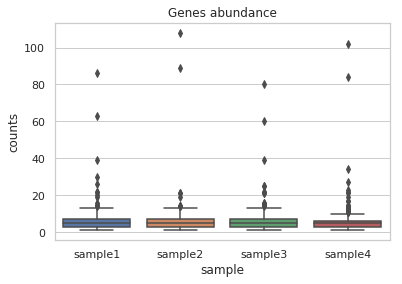

In [79]:
sns.set(style="whitegrid")
data = pd.melt(gene_counts_all)
ax = sns.boxplot(x="variable", y="value", data=data)
ax.set(xlabel='sample', ylabel='counts', title="Genes abundance")
plt.show()

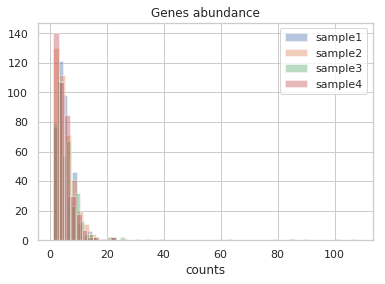

In [80]:
for sample in gene_counts_all.columns:
#     ax = sns.distplot(gene_counts_all[sample].dropna(), kde=True, kde_kws = {'shade': True, 'linewidth': 3}, 
#                       hist=False, label=sample)
    ax = sns.distplot(gene_counts_all[sample].dropna(), kde=False, hist=True, label=sample)
ax.set(xlabel='counts', title="Genes abundance")
ax.legend()
plt.show()